#  Identify markers (TF-IDF) and DEGs mouse somatic celltypes

In [44]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


sc.set_figure_params(figsize=(4, 4))

In [45]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig('barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [46]:
df = pd.read_csv('stressgenes_vandenBrink2017.csv')
stress_genes = df['gene'].tolist()

### Load data

In [47]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path_to_gonads + 'mouse-gonads_somatic.h5ad')

In [48]:
adata.obs['celltype'].values.describe()

counts     freqs
categories                             
CoelEpi_Gata2            6143  0.117727
CoelEpi_Gata2_cycling     424  0.008126
CoelEpi_Lhx9             6632  0.127099
early_supporting         4072  0.078038
sPAX8                    1689  0.032369
preGC_I                  4719  0.090437
OSE                      1031  0.019759
preGC_II                 7556  0.144806
granulosa                1919  0.036777
Sertoli                  1516  0.029053
Gi                       5836  0.111844
Oi                       7649  0.146589
Ti                       2019  0.038693
FetalLeydig               199  0.003814
Doublet                    34  0.000652
lowQC                     523  0.010023
cont                      219  0.004197

In [49]:
# Remove non confident cells
adata = adata[[ not pd.isna(i) for i in adata.obs.celltype ]]
adata = adata[[i not in ['cont', 'lowQC', 'Doublet'] for i in adata.obs.celltype]]
adata.obs['celltype'].values.describe()

counts     freqs
categories                             
CoelEpi_Gata2            6143  0.119504
CoelEpi_Gata2_cycling     424  0.008248
CoelEpi_Lhx9             6632  0.129017
early_supporting         4072  0.079216
sPAX8                    1689  0.032857
preGC_I                  4719  0.091802
OSE                      1031  0.020057
preGC_II                 7556  0.146992
granulosa                1919  0.037332
Sertoli                  1516  0.029492
Gi                       5836  0.113532
Oi                       7649  0.148802
Ti                       2019  0.039277
FetalLeydig               199  0.003871

In [50]:
# To even male/female pre-supporting, combine name with sex
adata.obs['celltype2'] = adata.obs['celltype'].tolist()
mask1 = np.array([i in 'early_supporting' for i in adata.obs['celltype']])
adata.obs.loc[mask1, 'celltype2'] = 'early_supporting_female'

mask2 = np.array([i in 'male' for i in adata.obs['sex']])
mask = [all(tup) for tup in zip(mask1, mask2)]
adata.obs.loc[mask, 'celltype2'] = 'early_supporting_male'
adata.obs['celltype2'] = adata.obs['celltype2'].astype('category')

Trying to set attribute `.obs` of view, copying.


In [51]:
# Remove stress genes
adata = adata[:,[i not in stress_genes for i in adata.var_names]]

# remove mito genes
non_mito_genes = [name for name in adata.var_names if not name.startswith('mt-')]
adata = adata[:, non_mito_genes]

# # remove ribo genes
# non_ribo_genes = [name for name in adata.var_names if not name.startswith('Rp')]
# adata = adata[:, non_ribo_genes]

# remove lowly expressed genes
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.


## All celltypes - markers 

### TF-IDF

In [9]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
adataDown = sc.pp.subsample(XX, fraction=0.75, random_state=0, copy=True)
sc.pp.filter_genes(adataDown, min_cells=3)

In [10]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [11]:
# To avoid complains from R
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage', 'dataset', 'tissue', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)
del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [12]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 20708 10032 
metadata(0):
assays(1): X
rownames(20708): 0610005C13Rik 0610009B22Rik ... a ccdc198
rowData names(72): gene_ids.0.Niu2020 feature_types.0.Niu2020 ...
  highly_variable_nbatches n_cells
colnames(10032): HCA_Mou_10828701_CGGACTGGTTTAAGCC-Sanger
  HCA_Mou_10828699_TTGACTTTCACTTATC-Sanger ...
  HCA_Mou_10827183_CAGATCAAGCAACGGT-Sanger
  HCA_Mou_10827184_CCGGGATCACACATGT-Sanger
colData names(6): previous_celltype stage_merged ... sex_celltype
  celltype2
reducedDimNames(0):
altExpNames(0):


In [13]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype
# Idents(seurat_andata) = seurat_andata$leiden_fake


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 100)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

... storing 'celltype' as categorical


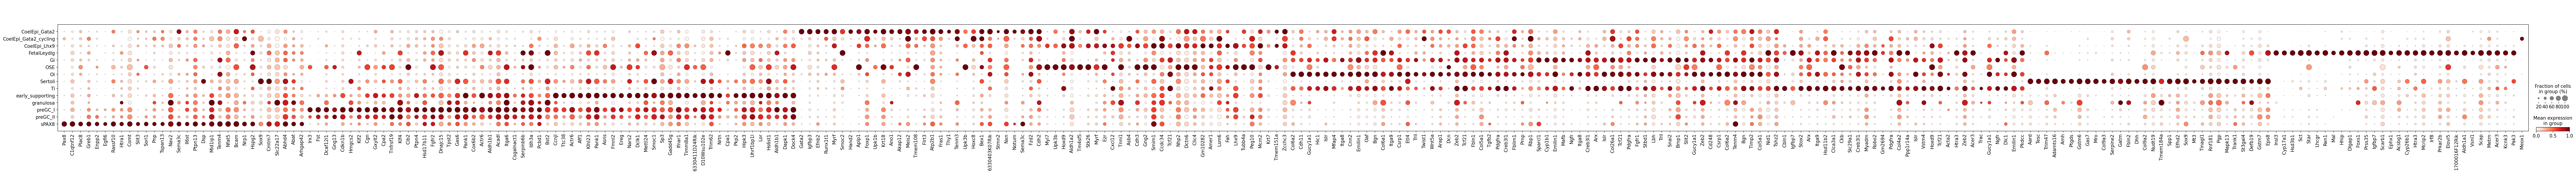

In [14]:
df_tfIDF.to_csv(path_to_gonads + 'mouse-gonads_somatic_TFIDF.tsv', index=False, sep='\t')

sc.pl.dotplot(adataDown, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_mouse_somatic_TFIDF.pdf')#topgenes_tfIDF

In [15]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)


In [16]:
DEGs.to_csv(path_to_gonads + 'mouse-gonads_somatic_DEGs.tsv', index=False, sep='\t')

## Early somatic celltypes - markers 

In [17]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[ i in ["Sanger"] for i in XX.obs.dataset ]] # To avoid datasets specific genes
XX = XX[[ i not in ["Oi", "preGC_II", "granulosa", 'OSE', 'Ti', 'FetalLeydig'] for i in XX.obs.celltype ]]
adataDown = sc.pp.subsample(XX, fraction=0.5, random_state=0, copy=True)
sc.pp.filter_genes(adataDown, min_cells=3)

In [18]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [19]:
# To avoid complains from R
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage', 'dataset', 'tissue', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'previous_celltype', 'stage_merged',  'leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [20]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 20060 5991 
metadata(0):
assays(1): X
rownames(20060): 0610005C13Rik 0610009B22Rik ... a ccdc198
rowData names(72): gene_ids.0.Niu2020 feature_types.0.Niu2020 ...
  highly_variable_nbatches n_cells
colnames(5991): HCA_Mou_10828699_GGAATAAAGACAAAGG-Sanger
  HCA_Mou_10827181_TATTACCTCGGAAATA-Sanger ...
  HCA_Mou_10828699_TACCTTAGTTCAGCGC-Sanger
  HCA_Mou_10828699_GTTTCTACACCAACCG-Sanger
colData names(3): celltype sex_celltype celltype2
reducedDimNames(0):
altExpNames(0):


## TF-IDF

In [21]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype
# Idents(seurat_andata) = seurat_andata$leiden_fake


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 100)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

... storing 'celltype' as categorical


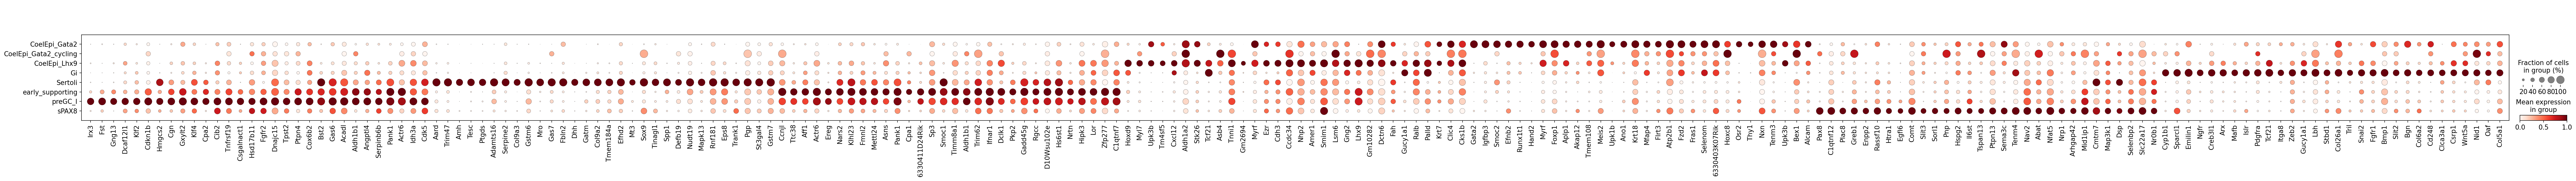

In [22]:
df_tfIDF.to_csv(path_to_gonads + 'mouse-gonads_somaticEarlySanger_TFIDF.tsv', index=False, sep='\t')

sc.pl.dotplot(adataDown, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_mouse_somaticEarlySanger_TFIDF.pdf')#topgenes_tfIDF

## pre-granulosa Niu cells - markers

In [52]:
import anndata
XX = adata[[ i in ["preGC_I", "preGC_II",  "granulosa", 'OSE', 'CoelEpi_Lhx9'] for i in adata.obs.celltype ]]
XX = XX[[ i not in ["Sanger"] for i in XX.obs.dataset ]] # this is to avoid dataset specific genes
adataDown = sc.pp.subsample(XX, fraction=0.5, random_state=0, copy=True)
sc.pp.filter_genes(adataDown, min_cells=3)

In [60]:
adataDown.obs['celltype'].values.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [53]:
import rpy2.rinterface_lib.callbacks
import logging
# Itoliste R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [54]:
# To avoid complains from R
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage', 'dataset', 'tissue', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'previous_celltype', 'stage_merged','leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [55]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 18880 7409 
metadata(0):
assays(1): X
rownames(18880): 0610005C13Rik 0610009B22Rik ... Zzz3 a
rowData names(72): gene_ids.0.Niu2020 feature_types.0.Niu2020 ...
  highly_variable_nbatches n_cells
colnames(7409): GSM4643735_E16.5ovary_GCAACCGAGAAATTGC-Niu2020
  GSM4643737_P1ovary_AGATCTGCATCGTCGG-Niu2020 ...
  GSM4643734_E14.5ovary_CTACCCAGTGGCCCTA-Niu2020
  GSM4643736_E18.5ovary_GGAATAAGTAGGACAC-Niu2020
colData names(3): celltype sex_celltype celltype2
reducedDimNames(0):
altExpNames(0):


## TF-IDF

In [56]:
%%R -o df_tfIDF -o topgenes_tfIDF

library(Seurat)
library(SoupX)
library(dplyr)
seurat_andata = as.Seurat(adataDown, counts = "X", data = "X")
Idents(seurat_andata) = seurat_andata$celltype
# Idents(seurat_andata) = seurat_andata$leiden_fake


df_tfIDF = quickMarkers(toc = seurat_andata@assays$RNA@counts, clusters = Idents(seurat_andata), N = 100)

df_tfIDF$cluster = factor(df_tfIDF$cluster, levels = levels(Idents(seurat_andata)) )
topgenes_tfIDF = subset(df_tfIDF, qval <= 0.05) %>%
  group_by(cluster) %>%
  group_map(~ head(.x, 30L)$gene) %>%
  unlist(.)

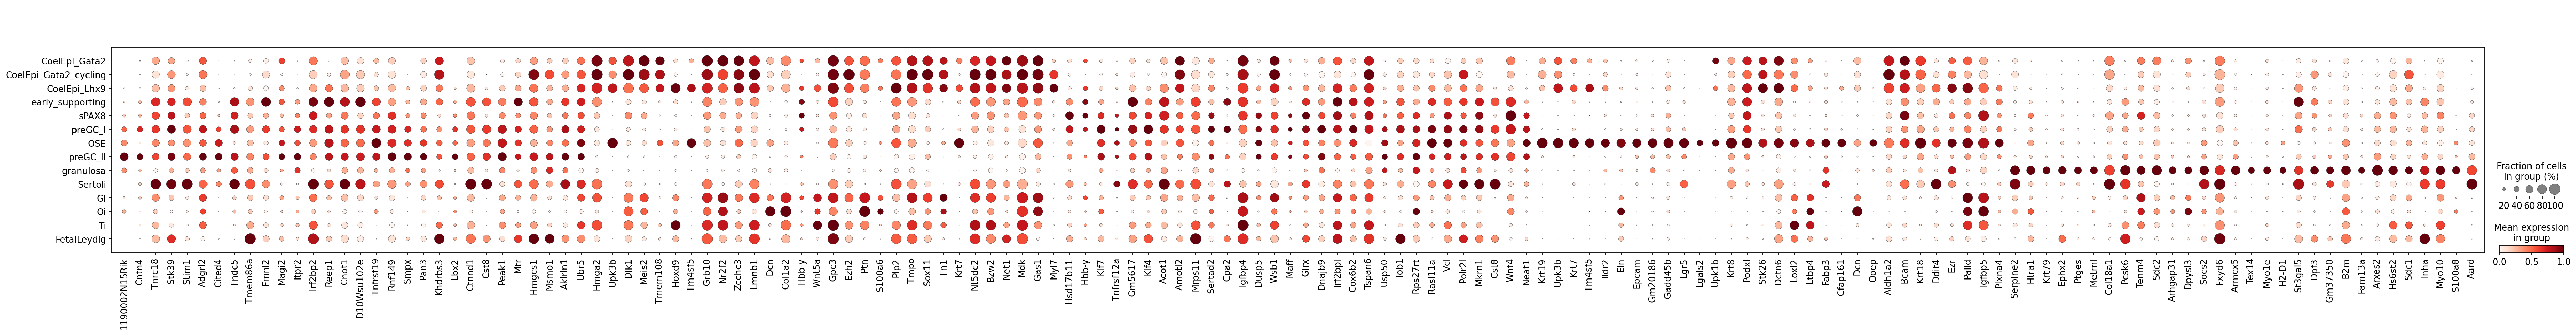

In [57]:
df_tfIDF.to_csv(path_to_gonads + 'mouse-gonads_pregranulosa_TFIDF.tsv', index=False, sep='\t')

sc.pl.dotplot(adata, list(topgenes_tfIDF), groupby='celltype', standard_scale = 'var', save='_mouse_pregranulosa_TFIDF.pdf')#topgenes_tfIDF

### DEGs

In [58]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$celltype

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))


# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0, 
                       min.pct = 0, 
                       return.thresh = 1)

In [59]:
DEGs.to_csv(path_to_gonads + 'mouse-gonads_pregranulosa_DEGs.tsv', index=False, sep='\t')

# Sexually dimorphic genes in early somatic

## Identify recurrent sexually dimorphic genes 

Unbiased identification of recurrent sexually dimorphic genes by doing DEG analysis in all somatic populations.
We need these genes to removed them as these are non-population specific.

In [31]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[ i in ['CoelEpi_Lhx9', 'Gi', 'early_somatic', 'early_supporting', 'sPAX8']  for i in XX.obs.celltype ]]
adataDown = XX[[ i in ["11.5"] for i in XX.obs.stage ]]

sc.pp.filter_cells(adataDown, min_genes=3000)
adataDown.obs['celltype'].value_counts()

Trying to set attribute `.obs` of view, copying.


early_supporting    1964
Gi                  1013
CoelEpi_Lhx9         524
sPAX8                365
Name: celltype, dtype: int64

In [32]:
#  Downsample to the smallest pop size
target_cells = 362

adataDown.obs['cell'] = adataDown.obs.index
adatas = [adataDown[adataDown.obs['celltype'].isin([cl])] for cl in adataDown.obs['celltype'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown = adataDown[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown.obs['cell'] ]]

sc.pp.filter_genes(adataDown, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [33]:
# To avoid complains from R
adataDown.X = adataDown.X.toarray()

idx = ['n_genes', 'sample', 'stage', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage', 'dataset', 'tissue', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'previous_celltype', 'stage_merged','leiden_R']
for i in idx:
    del adataDown.obs[i]
    
adataDown.obs['celltype'] = adataDown.obs['celltype'].astype(str)

del adataDown.obsm['X_scVI']
del adataDown.obsm['X_umap']
del adataDown.obsp['connectivities']
del adataDown.obsp['distances']
del adataDown.uns

In [34]:
%%R -i adataDown
adataDown

class: SingleCellExperiment 
dim: 13746 1448 
metadata(0):
assays(1): X
rownames(13746): 0610005C13Rik 0610009B22Rik ... Zzef1 Zzz3
rowData names(72): gene_ids.0.Niu2020 feature_types.0.Niu2020 ...
  highly_variable_nbatches n_cells
colnames(1448): HCA_Mou_10827183_AAACCTGGTGCTGTAT-Sanger
  HCA_Mou_10827183_AAACCTGTCCCTAATT-Sanger ...
  HCA_Mou_10828702_TGCGTGGCAACGATCT-Sanger
  HCA_Mou_10828702_TTCTACACAGGTCTCG-Sanger
colData names(5): sex celltype sex_celltype celltype2 cell
reducedDimNames(0):
altExpNames(0):


In [35]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown, counts = "X", data = "X")
Idents(so) = so$sex

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- ScaleData(so, features = rownames(so))


# Extract DEGs for each cell_type
for (cl in unique(so$celltype) ){
    print(cl)
    so_cl =  subset(so, cells = colnames(so)[ so$celltype == cl ] )
    DEGs <- FindAllMarkers(so_cl, 
                           verbose = F, 
                           only.pos = T, 
                           random.seed = 1, 
                           logfc.threshold = 0.1, 
                           min.pct = 0.1, 
                           return.thresh = 1)
    DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]
    write.csv(DEGs, file = paste0('mouse_sexDim_',cl,'.csv'), quote = F, row.names = F)
}

[1] "early_supporting"
[1] "sPAX8"
[1] "CoelEpi_Lhx9"
[1] "Gi"


In [36]:
%%R -o sex_genes

sex_genes = list()
for( cl in c('CoelEpi_Lhx9', 'Gi', 'early_somatic', 'early_supporting', 'sPAX8') ){
    df = read.csv(paste0('mouse_sexDim_',cl,'.csv'), stringsAsFactors = F)
    sex_genes[[cl]] = subset(df, p_val < 0.05)$gene
}
sex_genes = Reduce(intersect, sex_genes)
all(c('Xist', 'Eif2s3y', 'Ddx3y', 'Kdm5d', 'Uty') %in%  sex_genes)
sex_genes

 [1] "Xist"      "Eif2s3y"   "Ddx3y"     "Kdm5d"     "Uty"       "Bola2"    
 [7] "Ndufb1-ps" "Ndufa3"    "Atp5k"     "Romo1"     "Pet100"    "Tmem256"  
[13] "Anapc13"   "Tomm7"     "Atp5mpl"   "AA465934"  "Snhg8"     "Atp5md"   
[19] "Gm47283"   "Dpm3"      "Rpl38"     "Cox17"     "Ndufa1"    "Uqcr11"   
[25] "Cops9"     "Ndufa5"    "Rbis"      "Rps21"     "Ndufc1"    "Mrpl52"   
[31] "Rnaset2a"  "Rps28"     "Snrpf"     "Rps29"     "Cox7c"     "Sec62"    
[37] "Tmem258"   "Ndufb2"    "Rpl37"     "Srek1ip1"  "Slirp"     "Snrpg"    
[43] "Cox20"     "Rps27"     "Lsm7"      "Atp5e"     "Rpl36"     "Ubl5"     
[49] "Rpl39"     "Ndufa2"    "Son"       "Csnk2a1"   "Tuba1b"    "Uqcrq"    
[55] "Rpl41"     "Rpl37a"    "Cox6c"     "Fmc1"      "Smim27"    "Atox1"    
[61] "Ndufb4"    "Atp5j2"    "Metap2"    "Polr2k"    "Rpl36a"    "Sec61g"   
[67] "Mrps21"    "Pin4"      "Cox7a2"    "Rpl31"     "Ndufa6"    "Cox7b"    
[73] "Cox6b1"    "Rpl35a"    "Gm11808"   "Tsix"      "Chchd2"    "Ndufv3"   

## Identify sexually dimorphic genes in early_supporting population

Identify genes that are sexually dimorphic only in the early_supporting population at the time of sex specification

In [37]:
import anndata
XX = adata[[ i in ["G1"] for i in adata.obs.phase ]]
XX = XX[[ i in ["11.5"] for i in XX.obs.stage ]]

adataDown_ES = XX[[ i in 'early_supporting' for i in XX.obs.celltype]]
sc.pp.filter_cells(adataDown_ES, min_genes=4000)
adataDown_ES.obs['celltype2'].value_counts()

Trying to set attribute `.obs` of view, copying.


early_supporting_female    1245
early_supporting_male       643
Name: celltype2, dtype: int64

In [38]:
#  Downsample to the smallest pop size
target_cells = 624

adataDown_ES.obs['cell'] = adataDown_ES.obs.index
adatas = [adataDown_ES[adataDown_ES.obs['celltype2'].isin([cl])] for cl in adataDown_ES.obs['celltype2'].cat.categories]

for dat in adatas:
    if dat.n_obs > target_cells:
        sc.pp.subsample(dat, n_obs=target_cells, random_state=0)
adata_downsampled = adatas[0].concatenate(*adatas[1:])
adataDown_ES = adataDown_ES[[ i in adata_downsampled.obs.cell.tolist() for i in adataDown_ES.obs['cell'] ]]

sc.pp.filter_genes(adataDown_ES, min_cells=20)

Trying to set attribute `.var` of view, copying.


In [39]:
# clean up andata for R
adataDown_ES.X = adataDown_ES.X.toarray()

idx = ['sample', 'stage', 'sex', 'location', 'percent_mito', 'n_counts', 'batch', 'S_score', 'G2M_score', 'phase', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'scmap_fromHuman', 'lineage', 'dataset', 'tissue', 'doublet_score', 'doublet_score_0.75', 'leiden', 'cell_type', 'previous_celltype', 'stage_merged','leiden_R']
for i in idx:
    del adataDown_ES.obs[i]
    
adataDown_ES.obs['celltype2'] = adataDown_ES.obs['celltype2'].astype(str)

del adataDown_ES.obsm['X_scVI']
del adataDown_ES.obsm['X_umap']
del adataDown_ES.obsp['connectivities']
del adataDown_ES.obsp['distances']
del adataDown_ES.uns

In [40]:
%%R -i adataDown_ES
adataDown_ES

class: SingleCellExperiment 
dim: 13266 1248 
metadata(0):
assays(1): X
rownames(13266): 0610005C13Rik 0610009B22Rik ... Zzef1 Zzz3
rowData names(72): gene_ids.0.Niu2020 feature_types.0.Niu2020 ...
  highly_variable_nbatches n_cells
colnames(1248): HCA_Mou_10827183_AAACCTGGTCTTCGTC-Sanger
  HCA_Mou_10827183_AAACCTGGTGCTGTAT-Sanger ...
  HCA_Mou_10828701_TTTGTCAAGTGTCCCG-Sanger
  HCA_Mou_10828701_TTTGTCACATGCTAGT-Sanger
colData names(5): n_genes celltype sex_celltype celltype2 cell
reducedDimNames(0):
altExpNames(0):


In [41]:
%%R -o DEGs

library(Seurat)
so = as.Seurat(adataDown_ES, counts = "X", data = "X")
Idents(so) = so$celltype2

# Normalize
so <- NormalizeData(so, normalization.method = "LogNormalize", scale.factor = 10000)
so <- FindVariableFeatures(so)
so <- ScaleData(so, features = rownames(so))

# Extract DEGs for each cell_type
DEGs <- FindAllMarkers(so, 
#                        test.use = 'LR', 
                       verbose = F, 
                       only.pos = T, 
                       random.seed = 1, 
                       logfc.threshold = 0.01, 
                       min.pct = 0.1, 
                       return.thresh = 1)

DEGs = DEGs[ order(DEGs$avg_logFC, decreasing=T) , ]
DEGs[which(DEGs$gene == 'Sry'),]

          p_val avg_logFC pct.1 pct.2   p_val_adj               cluster gene
Sry 3.99764e-40 0.2736704 0.248     0 5.30327e-36 early_supporting_male  Sry


In [42]:
DEGs.to_csv(path_to_gonads+'/mouse-gonads_somaticEarly_earlysupporting_DEGs.tsv', index=False, sep='\t')

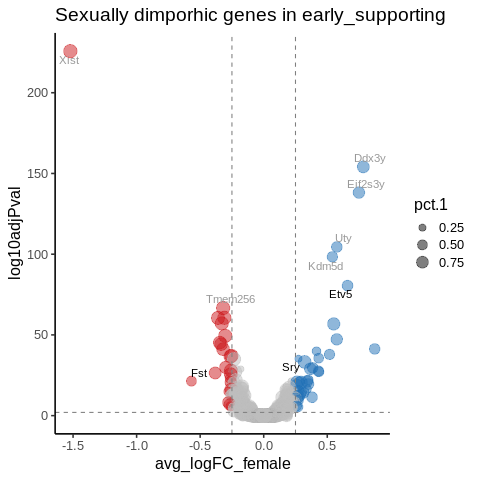

In [43]:
%%R -o DEGs -i path_to_gonads -i sex_genes

sex_genes

library(ggplot2)
library(RColorBrewer)

fe = 'early_supporting_female'
df = DEGs
# df = df[ order(df$avg_logFC, decreasing = T) , ]
df = df[ order(df$p_val_adj, decreasing = F) , ]
df$pctsum = df$pct.1 + df$pct.2
df = subset(df, pctsum < 1.9 )
df$avg_logFC_female = df$avg_logFC
df$avg_logFC_female[ df$cluster == fe ] = -df$avg_logFC[ df$cluster == fe ]
df$log10adjPval = -log10(df$p_val_adj)
df$color = 'grey'
df$color[ df$avg_logFC_female > 0.25 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Blues')[4]
df$color[ df$avg_logFC_female < -0.25 & df$p_val_adj < 0.01] = brewer.pal(n=4, 'Reds')[4]
n=7
df$label = ''
df$label2 = ''
df$label[ which(df$p_val_adj < 0.01)[1:n] ] = df$gene[ which(df$p_val_adj < 0.01 )[1:n] ]
df$label2[ which( df$label != '' & df$gene %in% sex_genes) ] = df$gene[ which(df$label != '' & df$gene %in% sex_genes)]
df$label[ df$gene %in% sex_genes ] = ''
df$label[ df$gene == 'Sry' ] = 'Sry'
# df$label[ df$gene == 'Sox9' ] = 'Sox9'
# df$label[ df$gene == 'Irx3' ] = 'Irx3'
# df$label[ df$gene == 'Foxl2' ] = 'Foxl2'
df$label[ df$gene == 'Fst' ] = 'Fst'
# df$label[ df$gene == 'H1fx' ] = 'H1fx'
# df$label[ df$gene == 'Ptov1' ] = 'Ptov1'


library(ggrepel)
p = ggplot(df, aes(y=log10adjPval, x=avg_logFC_female, color = color, size = pct.1)) + geom_point(alpha=0.5) + 
    scale_color_identity() + theme_classic(16) +
    geom_text_repel(data=df, aes(label=label2), color = 'grey60', size = 4) + 
    geom_text_repel(data=subset(df, label != ''), aes(label=label), color = 'black', size = 4) + 
    geom_hline(yintercept = -log10(0.01), color = 'grey50', linetype = "dashed") +
    geom_vline(xintercept = 0.25, color = 'grey50', linetype = "dashed") +
    geom_vline(xintercept = -0.25, color = 'grey50', linetype = "dashed") +
    ggtitle('Sexually dimporhic genes in early_supporting')
p
ggsave(filename = 'mouse_earlysupporting_volcanoDEGs.pdf', dpi = 75, height = 6, width = 6)
p

# df[which(df$gene %in% c('Sry','ETV5', 'Sox9',  'Foxl2', 'Reln')), ]